**Версии библиотек:**

- pandas 2.1.4
- numpy 1.26.4
- statsmodels 0.14.0
- seaborn 0.13.2
- matplotlib 3.8.0
- scikit-learn 1.2.2

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white

import random

RANDOM_STATE = 42

In [3]:
def metrics_report(y_true, y_pred):
    print(f'R2 score: {r2_score(y_true, y_pred)}')
    print(f'RMSE: {mean_squared_error(y_true, y_pred)**0.5}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')

#### Задание 1


Линейная регрессия позволяет проверить гипотезу об отличии коэффициента от нуля.

Пусть имеется набор данных о стоимости какого-то товара. В таблице две колонки: значение некоторой характеристики товара и его стоимость в рублях. Постройте линейную регрессию из sklearn и statsmodels и выберите все верные ответы.

In [12]:
# Загрузите данные из файла task0.csv и выведите первые 5 строк на экран
df = pd.read_csv('task0.csv')
df.head(6)
df.columns

Index(['Unnamed: 0', 'feature', 'cost'], dtype='object')

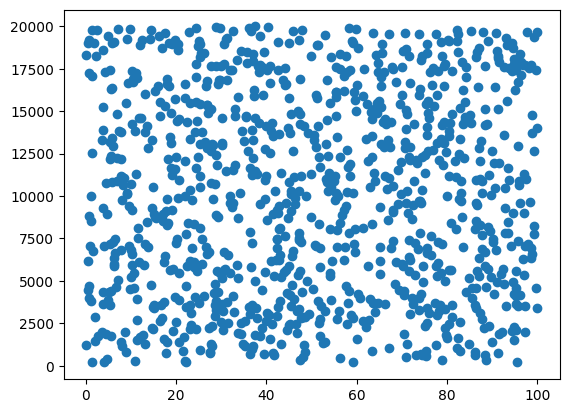

In [14]:
# Постройте scatterplot
plt.scatter(
    x = df['feature'],
    y = df['cost']
)
plt.show()

In [17]:
# Отнормируйте значения в колонках датафрейма для удобства интерпретации коэффициентов регрессии, поделив их на максимальные значения
df_normalized = df.apply(lambda x: x / x.max())
df_normalized.head(10)

,Unnamed: 0,feature,cost
0,0.000000,0.181953,0.608724
1,0.001001,0.048646,0.971987
2,0.002002,0.058769,0.541043
3,0.003003,0.993314,0.389125
4,0.004004,0.599786,0.993547
5,0.005005,0.319743,0.274023
6,0.006006,0.927877,0.524686
7,0.007007,0.687758,0.304487
8,0.008008,0.519296,0.088840
9,0.009009,0.337101,0.435846


In [25]:

df_normalized["feature"].head(10)
df_normalized["feature"].shape

(1000,)

In [35]:
# Постройте модель линейной регрессии из sklearn, обучите ее на всем датафрейме и выведите на экран коэффициенты
lin_reg = LinearRegression()
lin_reg.fit(df_normalized[['feature']], df_normalized[['cost']])
print(lin_reg.coef_, lin_reg.score(df_normalized[['feature']], df_normalized[['cost']]))


[[0.03033251]] 0.000893426341328496


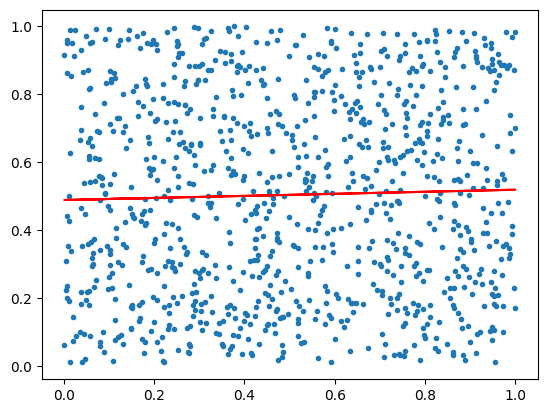

In [30]:
# График предсказаний регрессии
plt.scatter(x=df_normalized['feature'], y=df_normalized['cost'], marker='.')
plt.plot(df_normalized['feature'], lin_reg.predict(df_normalized[['feature']]), color='r')
plt.show()

In [34]:
# Теперь постройте регрессию из statsmodels. Но прежде чем это сделать, необходимо добавить в выборку константу с помощью функции sm.add_constant().
# Это необходимое техническое действие, без которого предсказания модели будут некорректными
X = df_normalized[['feature']] 
Y = df_normalized[['cost']]
X_sm = sm.add_constant(X)
model_sm = sm.OLS(Y, X_sm).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                   cost   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8924
Date:                Thu, 12 Sep 2024   Prob (F-statistic):              0.345
Time:                        22:24:01   Log-Likelihood:                -182.45
No. Observations:                1000   AIC:                             368.9
Df Residuals:                     998   BIC:                             378.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4885      0.019     26.345      0.0

#### Задание 2


Проверим предположение о необходимости репрезентативности выборки. Например, ограничим данные и сравним качество прогноза на полной и ограниченной выборках.

Пусть имеется набор данных о продажах домов. Рассмотрим две выборки, обучим на них модель линейной регрессии и сравним результаты. Первая выборка должна включать в себя только данные о домах, в которых не более 2 спальных комнат. Вторая выборка будет включать в себя все типы домов. Построить регрессию из statsmodels и в качестве ответа предоставить значения коэффициентов детерминации в обоих случаях (округлить до 3 знака)

Формат ответа: 0.333 0.342

In [4]:
# Считайте данные из файла house_prices.csv и выведите первые 5 строк на экран
data = pd.read_csv('house_prices.csv')
data.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished


In [5]:
# Создайте списки категориальных и количественных переменных (целевую переменную в списки не включать)
var_categorical = data.drop("price",axis = 1).select_dtypes(include='O').columns.values

var_categorical

array(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'], dtype=object)

In [6]:
# Сделайте две выборки, описанные в задании
X1 = data[data['bedrooms'] < 3]
X2 = data

X1[var_categorical].head(2)

,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus
61,yes,no,no,no,yes,no,semi-furnished
66,yes,no,yes,yes,no,no,furnished


In [7]:
y1 = X1['price']
y2 = X2['price']

In [8]:
def encode_yes_no(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

In [9]:
# Закодируйте категориальные признаки (там, где значения 'yes'/'no', просто замените из на 1/0, остальное - с помощью OneHotEncoder())

X1[var_categorical] = X1[var_categorical].map(encode_yes_no)
encoder = OneHotEncoder(sparse_output = False).set_output(transform='pandas')
encoded_data1 = encoder.fit_transform(X1[["furnishingstatus"]])

In [10]:
X2[var_categorical] = X2[var_categorical].map(encode_yes_no)
encoder = OneHotEncoder(sparse_output = False).set_output(transform='pandas')
encoded_data2 = encoder.fit_transform(X2[["furnishingstatus"]])

In [11]:
var_numeric = data.drop("price", axis = 1).select_dtypes(include=np.number).columns.values

In [12]:
# Теперь масштабируйте количественные признаки
scaler1 = StandardScaler()

X1_norm = pd.DataFrame(
    scaler1.fit_transform(X1[var_numeric]),
    columns=var_numeric
)

scaler2 = StandardScaler()

X2_norm =pd.DataFrame(
    scaler1.fit_transform(X2[var_numeric]),
    columns=var_numeric
)

In [13]:
X1_norm.head(1)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea
0,2.215891,0.121268,-0.248069,-0.390279,0.423659,-0.362143,-0.571772,-0.193892,2.296242,0.719969,-0.362143


In [14]:
encoded_data1.head(2)
encoded_data1 = encoded_data1.reset_index(drop=True)

In [15]:
encoded_data1.head(2)

,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,0.0,1.0,0.0
1,1.0,0.0,0.0


In [16]:
encoded_data1

,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,0.0,1.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
133,0.0,0.0,1.0
134,0.0,0.0,1.0
135,0.0,0.0,1.0
136,0.0,0.0,1.0


In [17]:
X1_norm.shape

(138, 11)

In [18]:

X1 = pd.concat([X1_norm.reset_index(drop=True), encoded_data1.reset_index(drop=True)], axis = 1)
X2 = pd.concat([X2_norm.reset_index(drop=True), encoded_data2.reset_index(drop=True)], axis = 1)

In [20]:
X1.head(10)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,2.215891,0.121268,-0.248069,-0.390279,0.423659,-0.362143,-0.571772,-0.193892,2.296242,0.719969,-0.362143,0.0,1.0,0.0
1,4.464476,0.121268,-0.248069,-0.390279,0.423659,-0.362143,1.748949,5.157519,-0.435494,0.719969,-0.362143,1.0,0.0,0.0
2,1.029138,0.121268,4.031129,6.634747,0.423659,-0.362143,1.748949,-0.193892,-0.435494,-0.679407,2.761340,1.0,0.0,0.0
3,1.107214,0.121268,-0.248069,-0.390279,0.423659,2.761340,1.748949,-0.193892,-0.435494,2.119344,2.761340,1.0,0.0,0.0
4,1.133239,0.121268,-0.248069,-0.390279,0.423659,2.761340,1.748949,-0.193892,-0.435494,2.119344,-0.362143,1.0,0.0,0.0
5,3.059110,0.121268,-0.248069,-0.390279,0.423659,-0.362143,-0.571772,-0.193892,-0.435494,0.719969,-0.362143,0.0,1.0,0.0
6,-0.011874,0.121268,4.031129,-0.390279,0.423659,-0.362143,-0.571772,-0.193892,2.296242,2.119344,-0.362143,0.0,1.0,0.0
7,3.532771,0.121268,-0.248069,1.951396,0.423659,-0.362143,-0.571772,-0.193892,-0.435494,-0.679407,2.761340,1.0,0.0,0.0
8,0.571093,0.121268,-0.248069,1.951396,0.423659,-0.362143,-0.571772,-0.193892,2.296242,-0.679407,2.761340,0.0,0.0,1.0
9,-0.563610,0.121268,-0.248069,-0.390279,-2.360387,2.761340,1.748949,-0.193892,-0.435494,-0.679407,-0.362143,0.0,1.0,0.0


In [21]:
# Для удобства переименуйте колонки, получившиеся при кодировании признака 'furnishingstatus' и удалите одну лишнюю ('unfurnished')
X1_enc = X1.rename(columns={ "furnishingstatus_furnished" :"furnished ", "furnishingstatus_semi-furnished" : "semi-furnished", "furnishingstatus_unfurnished":"unfurnished"}).drop("unfurnished", axis = 1)


X2_enc = X2.rename(columns={ "furnishingstatus_furnished" :"furnished ", "furnishingstatus_semi-furnished" : "semi-furnished", "furnishingstatus_unfurnished":"unfurnished"}).drop("unfurnished", axis = 1)

In [22]:
# К обеим выборкам добавьте константу для работы с моделями из statsmodels, затем выполните сброс индексов в обеих сериях целевой переменной
x1 = sm.add_constant(X1_enc)
x2 = sm.add_constant(X2_enc)

In [23]:
x1.head(2)

,const,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished
0,1.0,2.215891,0.121268,-0.248069,-0.390279,0.423659,-0.362143,-0.571772,-0.193892,2.296242,0.719969,-0.362143,0.0,1.0
1,1.0,4.464476,0.121268,-0.248069,-0.390279,0.423659,-0.362143,1.748949,5.157519,-0.435494,0.719969,-0.362143,1.0,0.0


In [24]:
# Постройте модели, обучите их на соответствующих выборках и выведите информацию о моделях
ols1_res = sm.OLS(np.array(y1), x1).fit()
print(ols1_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     17.69
Date:                Fri, 13 Sep 2024   Prob (F-statistic):           1.83e-22
Time:                        01:52:51   Log-Likelihood:                -2030.0
No. Observations:                 138   AIC:                             4088.
Df Residuals:                     124   BIC:                             4129.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.261e+06   8.63e+04     

In [25]:
ols2_res = sm.OLS(np.array(y2), x2).fit()
print(ols2_res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Fri, 13 Sep 2024   Prob (F-statistic):          9.07e-123
Time:                        01:52:53   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.509e+06   8.21e+04     

In [26]:
# Вызвав функцию metrics_report, определенную в начале ноутбука, выведите на экран значения метрик
# при предсказании обеих моделей на полном наборе данных (то есть на выборке с номером 2)
metrics_report(np.array(y2), ols1_res.predict(x2))

R2 score: 0.12536427101006442
RMSE: 1747666.244575116
MAPE: 0.21634834090505184


In [27]:
metrics_report(np.array(y2), ols2_res.predict(x2))

R2 score: 0.6818018485540142
RMSE: 1054128.892633344
MAPE: 0.17193151915655358


In [157]:
x2

,const,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished
0,1.0,1.046726,1.403419,1.421812,1.378217,0.405623,-0.465315,-0.734539,-0.219265,1.472618,1.517692,1.804941,1.0,0.0,0.0
1,1.0,1.757010,1.403419,5.405809,2.532024,0.405623,-0.465315,-0.734539,-0.219265,1.472618,2.679409,-0.554035,1.0,0.0,0.0
2,1.0,2.218232,0.047278,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,-0.679063,1.517692,1.804941,0.0,1.0,0.0
3,1.0,1.083624,1.403419,1.421812,0.224410,0.405623,-0.465315,1.361397,-0.219265,1.472618,2.679409,1.804941,1.0,0.0,0.0
4,1.0,1.046726,1.403419,-0.570187,0.224410,0.405623,2.149083,1.361397,-0.219265,1.472618,1.517692,-0.554035,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1.0,-0.991879,-1.308863,-0.570187,-0.929397,0.405623,-0.465315,1.361397,-0.219265,-0.679063,1.517692,-0.554035,0.0,0.0,1.0
541,1.0,-1.268613,0.047278,-0.570187,-0.929397,-2.465344,-0.465315,-0.734539,-0.219265,-0.679063,-0.805741,-0.554035,0.0,1.0,0.0
542,1.0,-0.705921,-1.308863,-0.570187,-0.929397,0.405623,-0.465315,-0.734539,-0.219265,-0.679063,-0.805741,-0.554035,0.0,0.0,1.0
543,1.0,-1.033389,0.047278,-0.570187,-0.929397,-2.465344,-0.465315,-0.734539,-0.219265,-0.679063,-0.805741,-0.554035,1.0,0.0,0.0


#### Задание 3

Еще одно предположение, выполнение которого сильно влияет на результат работы линейной регрессии, - это предположение о строгой экзогенности. Суть заключается в следующем. Предположим, было составлено уравнение регрессии, в котором целевой признак `'y'` определяется признаком `'x'` и некоторой константой. Предположим также, что существует некоторый фактор `'t'`, который влияет и на `'x'`, и на `'y'`, однако в уравнении не присутствует. Это может быть какой-то невидимый нам, неявный фактор. Получается, что наше уравнение является неполным, не описывает картину в целом.

Пусть имеется набор данных из трех колонок: два признака (`'x'` и `'t'`) и таргет `'y'`. Необходимо (а) построить регрессию, используя только `'x'` и `'y'`; (б) построить регрессию на `'t'` и `'y'`. В качестве ответа выбрать верные значения коэффициентов детерминации

In [58]:
# Создание нормально распределенного шума
rng = np.random.RandomState(RANDOM_STATE)
mu, sigma = 0, 0.1
eps = rng.normal(mu, sigma, size=1000)

In [59]:
c_train = 0
c_test = 0.1

In [60]:
# Создание набора данных
t = np.linspace(0, 1, 1000)

y = np.log(1 + t)
x = t + eps

df = pd.DataFrame({'t' : t, 'x' : x, 'y' : y})
df.head()

,t,x,y
0,0.000000,0.049671,0.000000
1,0.001001,-0.012825,0.001001
2,0.002002,0.066771,0.002000
3,0.003003,0.155306,0.002999
4,0.004004,-0.019411,0.003996


In [61]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df[['x', 't']], df['y'], test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

X_train['x'] += c_train
X_test['x'] += c_test

In [62]:
# Постройте модель только на 'x' и 'y', посчитайте коэффициент детерминации на тестовой выборке

scaler1 = StandardScaler()

X_train = pd.DataFrame(
    scaler1.fit_transform(X_train),
    columns=X_train.columns
)
X_test = pd.DataFrame(
    scaler1.fit_transform(X_test),
    columns=X_test.columns
)
X_train =  sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model_x = sm.OLS(y_train.reset_index(drop=True), X_train[["const", "x"]]).fit()
metrics_report(y_test.reset_index(drop=True), model_x.predict(X_test[["const", "x"]]))

R2 score: 0.8810085504989625
RMSE: 0.06833907509265374
MAPE: 1309572695995.0688


In [70]:
lin_reg = LinearRegression()
lin_reg.fit(X_train[["const", "x"]], y_train.reset_index(drop=True))
print(lin_reg.coef_, lin_reg.score(X_test[["const", "x"]],y_test.reset_index(drop=True)))

[0.        0.1871074] 0.8810085504989627


In [64]:
# Постройте модель только на 't' и 'y', посчитайте коэффициент детерминации на тестовой выборке и сдайте ответ в гугл-форму
model_t = sm.OLS(y_train.reset_index(drop=True), X_train[["const", "t"]]).fit()
metrics_report(y_test.reset_index(drop=True), model_t.predict(X_test[["const", "t"]]))

R2 score: 0.9868719250221578
RMSE: 0.022699262305846353
MAPE: 673819583605.8092


In [71]:
print(model_x.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     5181.
Date:                Sun, 15 Sep 2024   Prob (F-statistic):          9.65e-297
Time:                        14:17:13   Log-Likelihood:                 802.01
No. Observations:                 600   AIC:                            -1600.
Df Residuals:                     598   BIC:                            -1591.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3919      0.003    150.741      0.0

Отсюда можно сделать вывод о том, что для корректной работы модели важно правильно выбрать признаки.

#### Задание 4

Вернемся к данным о продаже домов. Постройте матрицу корреляций числовых признаков для тренировочной выборки. Закодируйте категориальные и масштабируйте количественные. После 
этого постройте регрессию из statsmodels и, проанализировав ее выдачу, определите признаки, не являющиеся полезными для построения модели. В качестве ответа на вопрос введите значение коэффициента корреляции Пирсона между признаками 'bedrooms' и 'stories', а также признаки, которые не являются полезными для модели и p-value для них (все выводится через пробел, десятичный разделитель - точка)

<u>Формат ответа:</u> corr_coef feature feature_p_value

<u>Пример:</u> 0.001 mainroad 0.123

Вернемся к данным о продаже домов. Постройте матрицу корреляций числовых признаков для тренировочной выборки. Закодируйте категориальные и масштабируйте количественные. После 
этого постройте регрессию из statsmodels и, проанализировав ее выдачу, определите признаки, не являющиеся полезными для построения модели. В качестве ответа на вопрос введите значение коэфф
ициента корреляции Пирсона между признаками 'bedrooms' и 'stories', а также признаки, которые не являются полезными для модели и p-value для них (все выводится через пробел, десятичный разделитель - точка)

<u>Формат ответа:</u> corr_coef feature feature_p_value

<u>Пример:</u> 0.001 mainroad 0.123

In [4]:
# Снова считайте данные из файла house_prices.csv
data = pd.read_csv("house_prices.csv")

In [5]:
data.head(1)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished


In [6]:
# Создайте списки категориальных и количественных переменных
var_categorical = data.select_dtypes(include = "O").columns.values
var_numeric = data.select_dtypes(include = np.number).columns.values


In [7]:
# Разделите данные на тренировочную и тестовую выборки. ВАЖНО: здесь и везде далее, где это возможно, указывать параметр random_state=RANDOM_STATE.
# Размер тестовой выборки 0.4, перемешивание данных должно быть включено (параметр shuffle)
X, y = data.drop(columns = "price"), data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

In [8]:
X_train.shape

(327, 12)

In [9]:
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

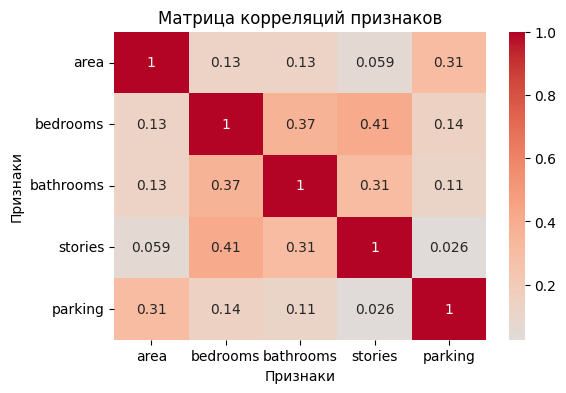

In [10]:
# Построить матрицу корреляций
var_numeric = np.delete(var_numeric, np.where(var_numeric == 'price'))
corr_matrix = X_train[np.delete(var_numeric, np.where(var_numeric == 'price'))].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций признаков')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

In [11]:
# Выполните кодирование категориальных и масштабирование количественных признаков (аналогично заданию 2).
# После этого соберите все в один датафрейм, переименуйте и удалите нужные колонки и сбросьте индексы в сериях целевой переменной
X_train[var_categorical] = X_train[var_categorical].replace({'yes' : 1, 'no' : 0})
X_test[var_categorical] = X_test[var_categorical].replace({'yes' : 1, 'no' : 0})

In [12]:
encoder = OneHotEncoder(sparse_output = False).set_output(transform='pandas')
encoded_X_train = encoder.fit_transform(X_train[["furnishingstatus"]])
encoded_X_test = encoder.fit_transform(X_test[["furnishingstatus"]])



X_train.drop(columns = "furnishingstatus", inplace = True)
X_test.drop(columns = "furnishingstatus", inplace = True)

In [13]:
scaler = StandardScaler()

X_train_norm = pd.DataFrame(
    scaler.fit_transform(X_train[var_numeric]),
    columns=var_numeric
)
X_test_norm = pd.DataFrame(
    scaler.fit_transform(X_test[var_numeric]),
    columns=var_numeric
)

In [14]:
var_categorical = np.delete(var_categorical, np.where(var_categorical == 'furnishingstatus'))

In [15]:
X_train_norm.reset_index(drop=True, inplace=True)
encoded_X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)

X_test_norm.reset_index(drop=True, inplace=True)
encoded_X_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [16]:
X_train = pd.concat([X_train_norm, encoded_X_train, X_train[var_categorical]],axis = 1)
X_test = pd.concat([X_test_norm, encoded_X_test, X_test[var_categorical]],axis = 1)

In [17]:
X_train.head(1)

,area,bedrooms,bathrooms,stories,parking,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea
0,-0.073972,-1.248938,-0.511306,0.279359,-0.777426,0.0,0.0,1.0,1,0,0,0,0,0


In [18]:
# Добавьте константы
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

In [19]:
# Постройте модель линейной регрессии из statsmodels и, проанализировав ее выдачу,
# найдите признаки, не являющиеся важными для модели и сдайте ответ в гугл-форму.
model = sm.OLS(y_train.values, X_train).fit()

In [20]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.659
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     46.60
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           3.00e-65
Time:                        20:10:24   Log-Likelihood:                -4965.2
No. Observations:                 327   AIC:                             9958.
Df Residuals:                     313   BIC:                         1.001e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
area      

In [ ]:
# Удалите признаки, которые не являются важными, чтобы не учитывать их в дальнейших исследованиях


#### Задание 5

Проверьте важность признаков. Для этого постройте регрессию только на площади квартиры и выберите в гугл-форме все верные ответы.

In [23]:
# Постройте регрессию из statsmodels только на площади (не забудьте добавить константы)
# ваш код здесь
data = pd.read_csv("house_prices.csv")


x_area = data['area']
y = data['price']
x_area = (x_area - x_area.mean())/x_area.std()


x_area = sm.add_constant(x_area)


model = sm.OLS(y.values, x_area).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     218.9
Date:                Sun, 15 Sep 2024   Prob (F-statistic):           7.39e-42
Time:                        20:13:49   Log-Likelihood:                -8551.2
No. Observations:                 545   AIC:                         1.711e+04
Df Residuals:                     543   BIC:                         1.712e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.767e+06   6.77e+04     70.408      0.0

In [24]:
# Теперь постройте регрессию на всех признаках
#R-squared =  0.659

In [25]:
# Анализируя выдачу statsmodels, выберите все верные ответы

#### Задание 6

Каково примерное изменение стоимости дома при увеличении количества этажей на два (разумеется, при прочих равных)? Проверить, построив линейную регрессию. В качестве ответа выбрать значение, максимально близкое к полученному Вами теоретически, и значение, максимально совпадающее с полученным путем построения линейной регрессии (при самостоятельном расчете взять разность средних значений)

In [ ]:
# В этом задании признак 'bedrooms' оставьте

In [172]:
data = pd.read_csv('house_prices.csv')
data.head()
y = data["price"]

In [173]:
# Создайте датафрейм, в котором количество этажей в каждом доме будет больше на два
df = data.copy()


In [174]:
df.head(2)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished


In [175]:
# Закодируйте категориальные и масштабируйте количественные признаки в обоих датафреймах
def encode_yes_no(x):
    if x == 'yes':
        return 1
    elif x == 'no':
        return 0
    else:
        return x

In [176]:
var_categorical = data.drop("price",axis = 1).select_dtypes(include='O').columns.values
var_categorical

array(['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus'], dtype=object)

In [177]:
df[var_categorical] = df[var_categorical].map(encode_yes_no)
encoder = OneHotEncoder(sparse_output = False).set_output(transform='pandas')
encoded_data1 = encoder.fit_transform(df[["furnishingstatus"]])



data[var_categorical] = data[var_categorical].map(encode_yes_no)
encoder2 = OneHotEncoder(sparse_output = False).set_output(transform='pandas')
encoded_data2 = encoder2.fit_transform(data[["furnishingstatus"]])


In [178]:
var_numeric = df.drop("price", axis = 1).select_dtypes(include=np.number).columns.values
var_numeric

array(['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea'], dtype=object)

In [179]:
std = df["stories"].std()
scaler1 = StandardScaler()
df_norm = pd.DataFrame(
    scaler1.fit_transform(df[var_numeric]),
    columns=var_numeric
)
scaler2 = StandardScaler()
data_norm = pd.DataFrame(
    scaler2.fit_transform(data[var_numeric]),
    columns=var_numeric
)

In [180]:
df = pd.concat([df_norm.reset_index(drop=True), encoded_data1.reset_index(drop=True)], axis = 1)
data = pd.concat([data_norm.reset_index(drop=True), encoded_data2.reset_index(drop=True)], axis = 1)

In [181]:

df["stories"] = data["stories"].apply(lambda x: x + 2/std)  
std

0.8674924629255264

In [57]:
data = sm.add_constant(data)
df = sm.add_constant(df)

ols_model = sm.OLS(np.array(y), data)
ols_res = ols_model.fit()

NameError: name 'df' is not defined

In [185]:
# Выполните предсказания на обоих наборах данных (data_sm и df_sm) и вычислите разность средних значений этих предсказаний. Сдайте ответ в гугл-форму

ols_model.predict(ols_res.params, df).mean() - ols_model.predict(ols_res.params, data).mean()

900868.3818578525

#### Задание 7

Теперь займемся проверкой допущений. Для начала проверим отсутствие мультиколлинеарности. Это можно сделать с помощью VIF (Variance Inflation Factor). Если он будет больше 4 (договорное значение, аналогичное p-value), то эта переменная коррелирует с какой-то из присутствующих, и ее нужно убрать.

Рассчитайте VIF для всех колонок и найдите те, которые коррелируют. После этого постройте две регрессии: с одним из коррелирующих признаков и с обоими (все остальные признаки тоже включаем, конечно). Выберите все верные ответы из списка.

In [52]:
# Снова считайте набор данных house_prices.csv, разделите его на тренировочную и тестовую выборки,
# закодируйте категориальные и масштабируйте количественнные признаки

data = pd.read_csv('house_prices.csv')
x = data.drop(columns = 'price')
var_categorical = x.select_dtypes(include = 'O').columns.values
var_numeric = x.select_dtypes(include = np.number).columns.values

x = x.replace({'yes' : 1, 'no' : 0})
encoder = OneHotEncoder()
encoder = OneHotEncoder(sparse_output = False).set_output(transform='pandas')
encoded_columns = encoder.fit_transform(x[["furnishingstatus"]])

scaler = StandardScaler()
normalized_columns = pd.DataFrame(
    scaler.fit_transform(x[var_numeric]),
    columns=var_numeric
)


x.drop(columns = 'furnishingstatus', inplace = True)
var_categorical = np.delete(var_categorical, var_categorical == 'furnishingstatus')

x = pd.concat([normalized_columns, x[var_categorical], encoded_columns], axis = 1)

In [53]:
x.head(1)

,area,bedrooms,bathrooms,stories,parking,mainroad,guestroom,basement,hotwaterheating,airconditioning,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,1.046726,1.403419,1.421812,1.378217,1.517692,1,0,0,0,1,1,1.0,0.0,0.0


In [54]:
# random_state=RANDOM_STATE, перемешивание включено, размер тестовой выборки 0.4
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=True, random_state=RANDOM_STATE)

In [55]:
# Вычислите VIF и найдите коррелирующие признаки
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
vif_data

,feature,VIF
0,area,1.339239
1,bedrooms,1.387938
2,bathrooms,1.248530
3,stories,1.561172
4,parking,1.185746
5,mainroad,1.194914
6,guestroom,1.302079
7,basement,1.403543
8,hotwaterheating,1.077502
9,airconditioning,1.308169


In [60]:
# Постройте регрессию из statsmodels, обучите ее на выборке без одного из коррелирующих признаков.
# Проделайте то же самое на выборке со всеми признаками.
new_columns = X_train.columns
new_columns = np.delete(new_columns, np.where(new_columns == "furnishingstatus_semi-furnished"))
model_without_semi_furnished = sm.OLS(y_train.values, X_train[new_columns]).fit()
model_with_all_features = sm.OLS(y_train.values, X_train).fit()
print(model_without_semi_furnished.summary())
print(model_with_all_features.summary())
# ваш код здесь

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.894
Method:                 Least Squares   F-statistic:                              212.0
Date:                Sun, 15 Sep 2024   Prob (F-statistic):                   8.59e-147
Time:                        21:48:43   Log-Likelihood:                         -5127.1
No. Observations:                 327   AIC:                                  1.028e+04
Df Residuals:                     314   BIC:                                  1.033e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

#### Задание 8

С помощью теста Уайта проверить отсутствие гетероскедастичности, то есть равенство дисперсий ошибок всех признаков. В качестве ответа сдать p-value этого теста.

О тесте Уайта. В качестве нулевой гипотезы примем равенство дисперсий ошибок всех признаков. Альтернатива, соответственно, будет за нарушение этого равенства. Если мы будем вынуждены отвергнуть нулевую гипотезу ($p-value < 0.05$), то можно будет сделать вывод о присутствии гетероскедастичности в наших данных.

Суть теста в следующем. Часто гетероскедастичность модели вызвана зависимостью (возможно, довольно сложной) дисперсий ошибок от признаков. На основе этого факта можно провести тест без каких-либо предположений о структуре гетероскедастичности. Сначала к исходной модели применяется обычный метод наименьших квадратов и находятся остатки регрессии $e_t$. Затем осуществляется регрессия квадратов этих остатков $e_t^2$ на все признаки, их квадраты, попарные произведения и константу. Тогда при гипотезе $H_0$ величина $NR^2$ асимптотически имеет распределение $\chi^2(N-1)$, где $R^2$ — коэффициент детерминации, а $N$ — число регрессоров второй регрессии. Плюс данного теста — его универсальность. Минусы : 1) если гипотеза $H_0$ отвергается, то никаких указаний на функциональную форму гетероскедастичности мы не получаем; 2) поиск вида регрессии вслепую (начинаем приближать простыми полиномами второй степени без какой бы то ни было причины на это)

In [89]:
# Для проведения теста Уайта постройте линейную регрессию, предварительно удалив признаки 'bedrooms' и 'special_index'
data = pd.read_csv('house_prices.csv')
y = data['price']
x = data.drop(columns = ['price'])
var_categorical = x.select_dtypes(include = 'O').columns.values
var_numeric = x.select_dtypes(include = np.number).columns.values

x = x.replace({'yes' : 1, 'no' : 0})
encoder = OneHotEncoder()
encoder = OneHotEncoder(sparse_output = False).set_output(transform='pandas')
encoded_columns = encoder.fit_transform(x[["furnishingstatus"]])
encoded_columns.drop(columns = ["furnishingstatus_semi-furnished"], inplace = True)


scaler = StandardScaler()
normalized_columns = pd.DataFrame(
    scaler.fit_transform(x[var_numeric]),
    columns=var_numeric
)


x.drop(columns = ['furnishingstatus'], inplace = True)
var_categorical = np.delete(var_categorical, var_categorical == 'furnishingstatus')

x = pd.concat([normalized_columns, x[var_categorical], encoded_columns], axis = 1)
x = sm.add_constant(x)
ols_res = sm.OLS(y, x).fit()
print(ols_res.summary())
# ваш код здесь

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     87.52
Date:                Sun, 15 Sep 2024   Prob (F-statistic):          9.07e-123
Time:                        23:05:41   Log-Likelihood:                -8331.5
No. Observations:                 545   AIC:                         1.669e+04
Df Residuals:                     531   BIC:                         1.675e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

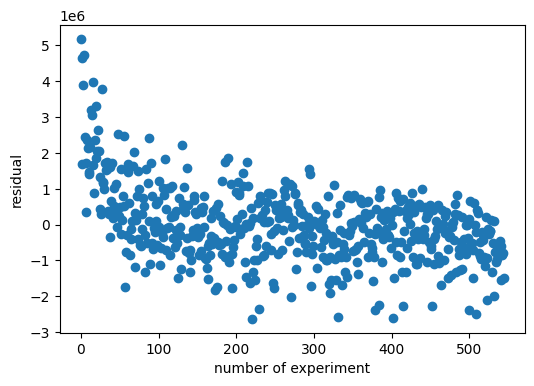

In [90]:
# Постройте график остатков от номера эксперимента
plt.figure(figsize=(6, 4))
plt.xlabel('number of experiment')
plt.ylabel('residual')
plt.scatter(x=list(range(ols_res.resid.shape[0])), y=ols_res.resid)
plt.show()

In [91]:
# Проведите тест Уайта
white_test = het_white(
    ols_res.resid,
    ols_res.model.exog
)

labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
p_value = white_test[1]

print("p-value:", p_value)
print(dict(zip(labels, white_test)))

p-value: 2.2646856968226932e-08
{'Test Statistic': 190.52878111650023, 'Test Statistic p-value': 2.2646856968226932e-08, 'F-Statistic': 2.540401416443483, 'F-Test p-value': 6.295242192376472e-11}


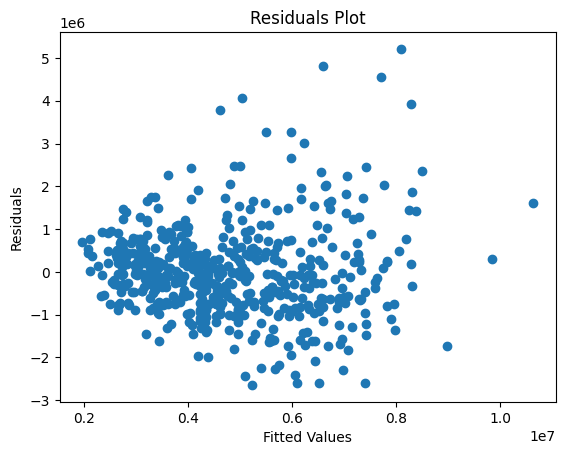

In [80]:
plt.scatter(ols_res.fittedvalues, ols_res.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [ ]:
# Сдайте результат в гугл-форму

#### Задание 9

Имеется набор данных о заболевании сахарным диабетом. В качестве признаков выступают пол, ИМТ и другие. Целевая переменная - некоторый медицинский показатель, связанный со степенью диабета. Проверить наличие мультиколлинеарности в данных. Построить обычную регрессию и посмотреть на ее коэффициенты при коррелирующих признаках. Затем построить регрессию с L1-регуляризацией (LASSO) и убедиться, что коэффициенты при коррелирующих признаках стремятся к нулю. В качестве ответа выберите признаки, при которых модель LASSO-регрессии занулила коэффициенты.

In [92]:
# Загрузите набор данных
from sklearn import datasets

diabetes = datasets.load_diabetes()

df = pd.DataFrame(diabetes.data)
df.columns = diabetes.feature_names

df['diabetes_measure'] = diabetes.target
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,diabetes_measure
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [96]:
# Нормируйте целевой признак на максимальное значение и разбейте данные на тренировочную и тестовую выборки.
# Размер тестовой выборки 0.25, перемешивание включено, random_state=RANDOM_STATE
X, y = df.drop(columns = 'diabetes_measure'), df['diabetes_measure']/df['diabetes_measure'].max()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state=RANDOM_STATE)

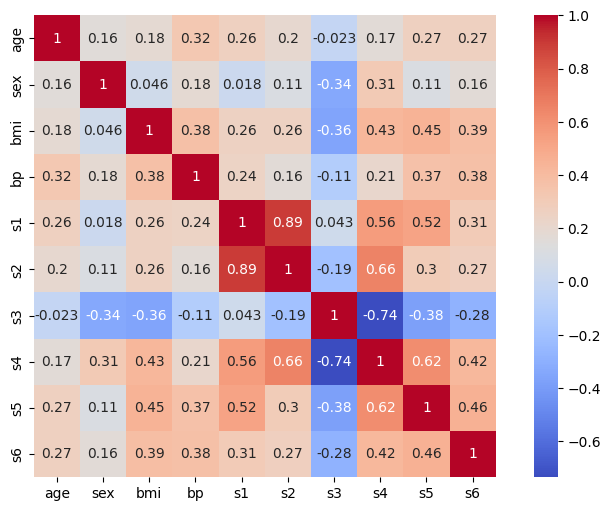

In [100]:
# Постройте матрицу корреляций
corr_matrix = X_train.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=True)
plt.show()

In [122]:
# Построить регрессию из sklearn, обучить ее и рассчитать метрику RMSE, используя функцию cross_val_score
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)


rmse = cross_val_score(
    estimator=lin_reg,
    X=X_train,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=10
)

-rmse.mean()

0.16086826334398505

In [123]:
# Выполнить предсказания и вывести метрики с помощью функции metrics_report
y_pred = lin_reg.predict(X_test)

metrics_report(y_test, y_pred)

R2 score: 0.46928407246725157
RMSE: 0.15656884455248607
MAPE: 0.38155454545123996


In [107]:
# Вывести отсортированные коэффициенты регрессии
coefs = []
for i in range(len(X_train.columns)):
    col = X_train.columns[i]
    coef = lin_reg.coef_[i]
    coefs.append((col, coef))

coefs.sort(key=lambda x: x[1], reverse=True)
for i in range(len(coefs)):
    print(f'{coefs[i][0]} : {coefs[i][1] : .2f}')

s5 :  2.01
bmi :  1.54
s2 :  1.47
bp :  1.10
s4 :  0.78
s3 :  0.34
age :  0.14
s6 :  0.08
sex : -0.70
s1 : -2.65


In [110]:
# Построить регрессию с L1-регуляризацией, осуществить автоматический поиск оптимальных гиперпараметров с помощью GridSearchCV.
# Обучить регрессию с оптимальными параметрами и, выведя ее коэффициенты, выяснить, какие признаки модель занулила
lasso = Lasso(max_iter=10000)

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}

clf = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=5)

clf.fit(X_train, y_train)

print("Коэффициенты модели:")
print(clf.best_estimator_.coef_)

zero_coefficients = [i for i, coef in enumerate(clf.best_estimator_.coef_) if coef == 0]
print("Признаки, которые модель занулила:")
print(X_train.columns[zero_coefficients].values)

Коэффициенты модели:
[ 0.         -0.          1.49569166  0.67281929 -0.         -0.
 -0.44754631  0.          0.99427318  0.        ]
Признаки, которые модель занулила:
['age' 'sex' 's1' 's2' 's4' 's6']


In [113]:
lasso = Lasso(alpha=clf.best_params_['alpha'], max_iter=10000) #(регрессия с L1-регуляризацией с оптимальными параметрами)
lasso.fit(X_train, y_train)

zero_coefficients = [i for i, coef in enumerate(lasso.coef_) if coef == 0]
print("Признаки, которые модель занулила:")
print(X_train.columns[zero_coefficients].values)

Признаки, которые модель занулила:
['age' 'sex' 's1' 's2' 's4' 's6']


In [ ]:
# Аналогично случаю обычной регрессии выведите коэффициенты модели для всех признаков, чтобы найти те, которые модель занулила

# Сдайте ответ в гугл-форме
# ваш код здесь

#### Задание 10

Рассмотрим все тот же набор данных о заболевании диабетом. Только теперь добавился еще один признак 's7'. Построить регрессию, затем применить регуляризацию и в качестве ответа сдать соответствующие коэффициенты детерминации, рассчитанные на тестовой выборке. Ответ округлить до третьего знака.

<u>Формат ответа:</u> lin_reg_r2 ridge_r2 lasso_r2

In [126]:
X_train['s7'] = np.sin(X_train['s3']) + X_train['s3'] ** 2 + X_train['s3']
X_test['s7'] = np.sin(X_test['s3']) + X_test['s3'] ** 2 + X_test['s3']

In [130]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,s7
16,-0.005515,-0.044642,0.042296,0.049415,0.024574,-0.023861,0.074412,-0.039493,0.052277,0.027917,0.154292
408,0.063504,-0.044642,-0.050396,0.107944,0.031454,0.019354,-0.017629,0.023608,0.058038,0.040343,-0.034947
432,0.009016,-0.044642,0.055229,-0.005670,0.057597,0.044719,-0.002903,0.023239,0.055686,0.106617,-0.005797
316,0.016281,0.050680,0.014272,0.001215,0.001183,-0.021355,-0.032356,0.034309,0.074966,0.040343,-0.063659
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,-0.070769


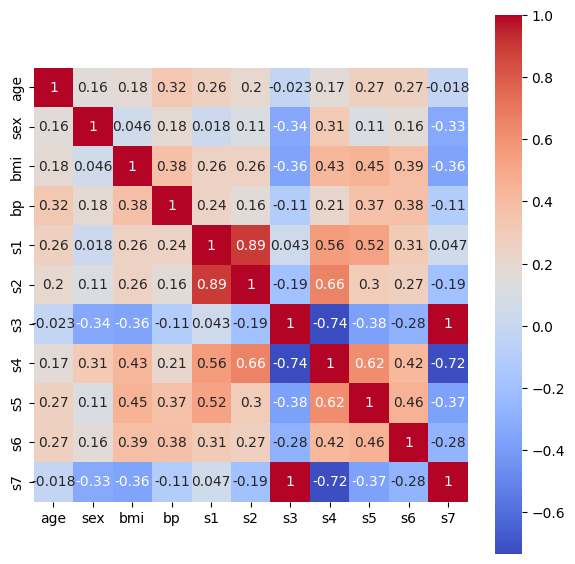

In [127]:
# Постройте матрицу корреляций
corr_matrix = X_train.corr()
plt.figure(figsize = (7, 7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=True)
plt.show()

In [143]:
# Постройте линейную регрессию из sklearn и оцените качество модели с помощью кросс-валидации, как в задании выше
lin_reg1 = LinearRegression()

rmse = cross_val_score(
    estimator=lin_reg1,
    X=X_train,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=10
)
lin_reg1.fit(X_train, y_train)
-rmse.mean()

0.16086826334398505

In [148]:
# Выполните предсказания на тренировочной и на тестовой выборках и по значениям коэффициента детерминации убедитесь в присутствии переобучения
y_train_pred = lin_reg1.predict(X_train)

y_test_pred = lin_reg1.predict(X_test)


print("train")
metrics_report(y_train, y_train_pred)
print("\ntest")
metrics_report(y_test, y_test_pred)

train
R2 score: 0.5209507347143025
RMSE: 0.1555244438406254
MAPE: 0.3898110259226531

test
R2 score: 0.46928407246725157
RMSE: 0.15656884455248607
MAPE: 0.38155454545123996


In [158]:
# Постройте регрессию с L2-регуляризацией, выполните предсказания на тренировочной и тестовой выборках (не забывайте про random_state)
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}

clf = GridSearchCV(ridge, params, scoring='neg_root_mean_squared_error', cv=5)
clf.fit(X_train, y_train)

ridge = Ridge(alpha=clf.best_params_['alpha'], random_state=RANDOM_STATE)
ridge.fit(X_train, y_train)

metrics_report(y_test, ridge.predict(X_test))

R2 score: 0.48111150693858695
RMSE: 0.15481438279378715
MAPE: 0.375076100421225


In [ ]:
# Обучите регрессию с оптимальными параметрами и выполните предсказания
# ваш код здесь

In [159]:
# Аналогично с LASSO-регрессией
lasso = Lasso(max_iter=10000)

params = {'alpha' : [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]}

clf = GridSearchCV(lasso, params, scoring='neg_root_mean_squared_error', cv=5)

clf.fit(X_train, y_train)

lasso = Lasso(alpha=clf.best_params_['alpha'], max_iter=10000)
lasso.fit(X_train, y_train)

metrics_report(y_test, ridge.predict(X_test))

R2 score: 0.48111150693858695
RMSE: 0.15481438279378715
MAPE: 0.375076100421225
